# Bayesian Normal Mean Model

The Bayesian normal mean model treats the **unknown** mean parameter as a **normally distributed** random variable reflecting our **uncertainty**, then updates this normal distribution by **conditioning on observed data** to yield a posterior normal distribution with **reduced uncertainty**.

# Graphical Summary

![Fig](./graphical_summary/slides/Slide26.png)

# Key Formula

Under the Bayesian regression setting, we have

$$
\mathbf{Y} = \mathbf{X} \beta + \boldsymbol{\varepsilon}, \quad \boldsymbol{\varepsilon} \sim \mathcal{N}(0, \sigma^2 \mathbf{I})
$$

with a **prior distribution** on the regression coefficient: $\beta \sim \mathcal{N}(\beta_0, \sigma_0^2)$.

- $\mathbf{Y} \in \mathbb{R}^{N}$: phenotype vector of $N$ samples
- $\mathbf{X} \in \mathbb{R}^{N}$: genotype vector of $N$ samples ($\mathbf{X}_i \in \{0, 1, 2\}$ for additive coding)
- $\beta \in \mathbb{R}$: genetic effect size
- $\boldsymbol{\varepsilon} \in \mathbb{R}^{N}$: residual error (i.i.d. Gaussian)
- $\sigma^2$: residual variance

# Technical Details

## The Bayesian Perspective

In Bayesian statistics, parameters are **random variables representing our uncertainty**, not fixed unknown constants. 

**Key insight**: When we cannot observe something, we treat it as a random variable with a probability distribution quantifying our uncertainty.

## Model Setup

$$
Y_i \sim \mathcal{N}(X_i\beta, \sigma^2) \quad \text{for } i = 1, 2, \ldots, N
$$

where $\beta$ is a **random variable** (we cannot observe the true genetic effect, so we quantify our uncertainty about it).

## Prior Distribution

$$
\beta \sim \mathcal{N}(\beta_0, \sigma_0^2)
$$

- $\beta_0$: Best guess before seeing data
- $\sigma_0^2$: How uncertain we are (larger = more uncertain)

The probability density function reflects this uncertainty:

$$
p(\beta) \propto \exp\left(-\frac{(\beta - \beta_0)^2}{2\sigma_0^2}\right)
$$

## Likelihood

The likelihood represents what we **can** condition on - the observed data given our uncertain parameter:

$$
Y_i\mid\beta, \sigma^2 \sim \mathcal{N}(X_i\beta, \sigma^2) \quad \text{for } i = 1, 2, \ldots, N
$$


$$
p(\mathbf{Y}\mid\beta) \propto \exp\left(-\frac{1}{2\sigma^2} \sum_{i=1}^N (Y_i - X_i\beta)^2\right)
$$


## Posterior Distribution

Using Bayes' theorem, we update our uncertainty given the observed data:

$$
p(\beta|\mathbf{Y}) \propto p(\mathbf{Y}|\beta) \cdot p(\beta)
$$

The posterior is:

$$
\beta \mid \mathbf{Y} \sim \mathcal{N}\left( \beta_1, \sigma_1^2 \right)
$$

where:

$$
\beta_1 = \frac{\frac{1}{\sigma^2} \sum_{i=1}^N X_i Y_i + \frac{1}{\sigma_0^2} \beta_0}{\frac{1}{\sigma^2} \sum_{i=1}^N X_i^2 + \frac{1}{\sigma_0^2}}, \quad \sigma_1^2 = \frac{1}{\frac{1}{\sigma^2} \sum_{i=1}^N X_i^2 + \frac{1}{\sigma_0^2}}
$$

Note: $\sigma_1^2 < \sigma_0^2$ always - **observing data reduces uncertainty**.


### Posterior as Weighted Average

$$
\beta_1 = w \cdot \hat{\beta}_{\text{data}} + (1-w) \cdot \beta_0
$$

where $w = \frac{T_1/\sigma^2}{T_1/\sigma^2 + 1/\sigma_0^2}$, $\hat{\beta}_{\text{data}} = T_2/T_1$, and $T_1 = \sum_{i=1}^N X_i^2$, $T_2 = \sum_{i=1}^N X_i Y_i$.

**Interpretation**:
- More data or lower noise → $w \approx 1$ (trust data)
- Vague prior (large $\sigma_0^2$) → $w \approx 1$ (data dominates)
- Strong prior (small $\sigma_0^2$) → $w \approx 0$ (prior dominates)

# Related Topics

- [ordinary least squares](https://statfungen.github.io/statgen-primer/ordinary_least_squares.html)
- [summary statistics](https://statfungen.github.io/statgen-primer/summary_statistics.html)
- [likelihood](https://statfungen.github.io/statgen-primer/likelihood.html)
- [maximum likelihood estimation](https://statfungen.github.io/statgen-primer/maximum_likelihood_estimation.html)

# Example

When studying genetic effects across many variants, we typically believe **most effects are small, some are moderate, and few are large**. Rather than assuming each effect is a fixed unknown constant, we model it as a **random variable drawn from a distribution**.

This leads to a **hierarchical structure**:

1. **Data level**: Phenotype depends on genotype and effect
2. **Effect level**: Effect $\beta$ is random, drawn from a distribution
3. **Hyperparameter level**: Distribution parameters estimated from data

**Model**:

$$
\begin{align}
Y_i | \beta, \sigma^2 &\sim \mathcal{N}(X_i \beta, \sigma^2) \quad \text{[likelihood]} \\
\beta | \sigma_0^2 &\sim \mathcal{N}(0, \sigma_0^2) \quad \text{[prior]} \\
\sigma_0^2 & \text{ estimated from data} \quad \text{[hyperparameter]}
\end{align}
$$

The posterior distribution $p(\beta | \mathbf{Y})$ shows how plausible each effect size is after combining prior knowledge with observed data.

**Why this matters**: In genomics with thousands of variants, treating effects as random with shared distributional properties is more realistic than treating each as an independent fixed unknown.

## Setup

First, let's recreate the exact same genetic data from our previous [Lecture: likelihood](https://statfungen.github.io/statgen-primer/likelihood.html).

In [16]:
# Clear the environment
rm(list = ls())
library(stats)
library(ggplot2)
set.seed(19)  # For reproducibility

# Generate genotype data for 5 individuals at a single variant
N <- 5
genotypes <- c("CC", "CT", "TT", "CT", "CC")  # Individual genotypes
names(genotypes) <- paste("Individual", 1:N)

# Define alternative allele
alt_allele <- "T"

# Convert to additive genotype coding (count of alternative alleles)
Xraw_additive <- numeric(N)
for (i in 1:N) {
  alleles <- strsplit(genotypes[i], "")[[1]]
  Xraw_additive[i] <- sum(alleles == alt_allele)
}
names(Xraw_additive) <- names(genotypes)

# Standardize genotypes
X <- scale(Xraw_additive, center = TRUE, scale = TRUE)[,1]

In [17]:
# Set true beta and generate phenotype data
true_beta <- 0.4
true_sd <- 1.0

# Generate phenotype with true effect
Y <- X * true_beta + rnorm(N, 0, true_sd)

To apply the Bayesian normal mean model, we need to specify the **prior distribution** for $\beta$ and the **residual variance** $\sigma^2$. We assume the prior mean is zero (i.e., we have no reason to believe the effect is positive or negative before seeing data):

$$
\beta \sim \mathcal{N}(\beta_0, \sigma_0^2) \quad \text{where } \beta_0 = 0
$$

The **prior variance** $\sigma_0^2$ represents how uncertain we are about $\beta$ before seeing data, and the **residual variance** $\sigma^2$ represents how noisy our measurements are. We will estimate both variances from the data using maximum likelihood.

## Prior Distribution

In [18]:
# Define prior distribution
# Prior mean: no prior expectation about direction of effect
beta_0 <- 0

cat("Prior distribution:\n")
cat("beta ~ N(beta_0, sigma_0^2) where beta_0 =", beta_0, "\n")
cat("sigma_0^2 will be estimated from data\n")

Prior distribution:
beta ~ N(beta_0, sigma_0^2) where beta_0 = 0 
sigma_0^2 will be estimated from data


## Estimating the Variances

**Why estimate variances?** We need $\sigma^2$ and $\sigma_0^2$ to compute the posterior, but we don't know their true values. In practice, we estimate them from the data itself.

**How?** We use the **marginal likelihood** - the probability of observing our data, averaging over all possible $\beta$ values:

$$
P(\mathbf{Y} | \sigma^2, \sigma_0^2) = \int P(\mathbf{Y} | \beta, \sigma^2) P(\beta | \sigma_0^2) d\beta
$$

For our normal-normal model, this has a closed form:

$$
\mathbf{Y} \sim \mathcal{N}(0, \sigma^2 \mathbf{I} + \sigma_0^2 \mathbf{X}\mathbf{X}^T)
$$

We find the $\sigma^2$ and $\sigma_0^2$ that maximize this marginal likelihood.

In [19]:
# Function to compute log marginal likelihood for given parameters
log_marginal_likelihood <- function(params, Y, X) {
  sigma_squared <- params[1]
  sigma_0_squared <- params[2]
  
  if (sigma_squared <= 0 || sigma_0_squared <= 0) return(-Inf)
  
  n <- length(Y)
  
  # Variance matrix: $\sigma^2$I + $\sigma_0^2$XX^T
  var_matrix <- sigma_squared * diag(n) + sigma_0_squared * outer(X, X)
  
  # Compute log likelihood of multivariate normal
  tryCatch({
    log_det <- determinant(var_matrix, logarithm = TRUE)$modulus
    quad_form <- t(Y) %*% solve(var_matrix) %*% Y
    
    # Log likelihood (ignoring constants)
    -0.5 * (log_det + quad_form)
  }, error = function(e) -Inf)
}

# Find optimal parameters by maximizing marginal likelihood
optimize_result <- optim(
  par = c(1, 0.5),  # Initial guesses for $\sigma^2$ and $\sigma_0^2$
  fn = function(params) -log_marginal_likelihood(params, Y, X),  # Minimize negative log-likelihood
  method = "L-BFGS-B",
  lower = c(0.01, 0.01),
  upper = c(10, 10)
)

sigma_squared_mle <- optimize_result$par[1]
sigma_0_squared_mle <- optimize_result$par[2]
sigma_mle <- sqrt(sigma_squared_mle)
sigma_0_mle <- sqrt(sigma_0_squared_mle)

print(paste("Estimated sigma^2 (error variance):", round(sigma_squared_mle, 3)))
print(paste("Estimated sigma_0^2 (prior variance):", round(sigma_0_squared_mle, 3)))


[1] "Estimated sigma^2 (error variance): 0.486"
[1] "Estimated sigma_0^2 (prior variance): 0.231"


## Posterior Distribution

With the estimated variances, we can now compute the posterior distribution using the formulas from the Technical Details section above.

In [20]:
# Calculate sufficient statistics
sum_X_squared <- sum(X^2)
sum_XY <- sum(X * Y)

# Posterior parameters using estimated variances and prior mean beta_0
posterior_variance <- 1 / (sum_X_squared/sigma_squared_mle + 1/sigma_0_squared_mle)
posterior_mean <- posterior_variance * (sum_XY/sigma_squared_mle + beta_0/sigma_0_squared_mle)
posterior_sd <- sqrt(posterior_variance)

cat("\nPosterior Results:\n")
cat("beta | D ~ Normal(", round(posterior_mean, 4), ", ", round(posterior_variance, 4), ")\n")
cat("Posterior mean (beta_1):", round(posterior_mean, 4), "\n")
cat("Posterior SD:", round(posterior_sd, 4), "\n")


Posterior Results:
beta | D ~ Normal( 0.3889 ,  0.0796 )
Posterior mean (beta_1): 0.3889 
Posterior SD: 0.2821 


## Visualizing the Bayesian Update

Let's visualize how observing data updates our beliefs about $\beta$, shifting from the prior to the posterior distribution.

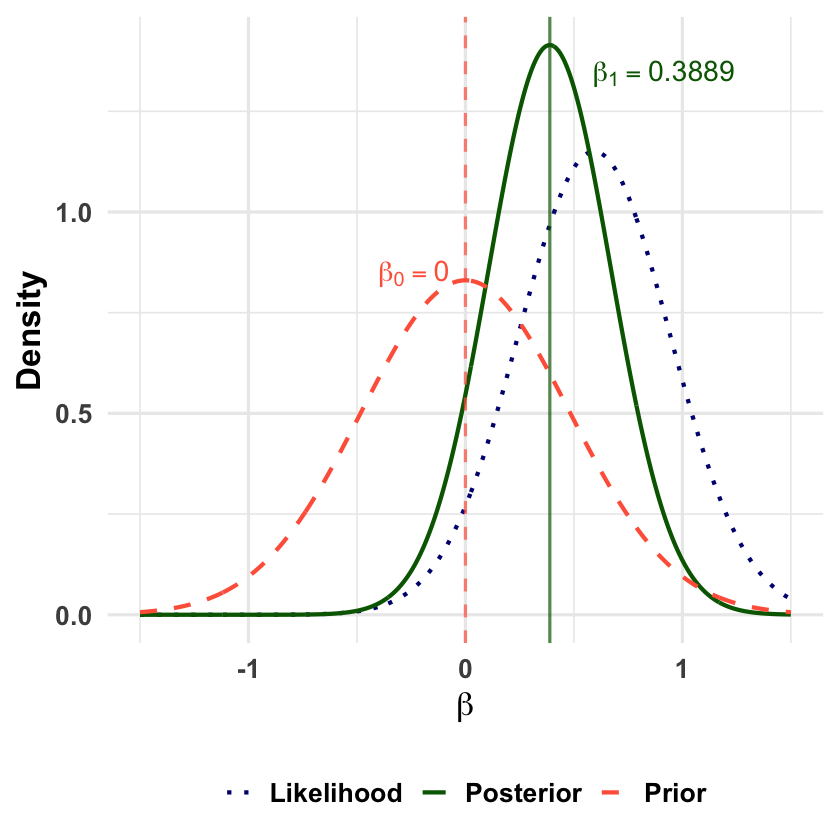

In [27]:
beta_range <- seq(-1.5, 1.5, length.out = 1000)

# Prior distribution: N(beta_0, sigma_0^2)
prior_density <- dnorm(beta_range, mean = beta_0, sd = sigma_0_mle)

# Likelihood (as a function of beta, treating data as fixed)
# This is proportional to exp(-(sum_X_squared * beta^2 - 2*sum_XY*beta) / (2*sigma^2))
likelihood_unnormalized <- exp(-(sum_X_squared * beta_range^2 - 2*sum_XY*beta_range) / (2*sigma_squared_mle))
# Normalize to make it a proper density
likelihood_density <- likelihood_unnormalized / (sum(likelihood_unnormalized) * (beta_range[2] - beta_range[1]))

# Posterior distribution: N(posterior_mean, posterior_variance)
posterior_density <- dnorm(beta_range, mean = posterior_mean, sd = posterior_sd)

# Combine into data frame
plot_data <- data.frame(
  beta = rep(beta_range, 3),
  density = c(prior_density, likelihood_density, posterior_density),
  distribution = rep(c("Prior", "Likelihood", "Posterior"), each = length(beta_range))
)

# Create the plot
p <- ggplot(plot_data, aes(x = beta, y = density, color = distribution, linetype = distribution)) +
  geom_line(size = 1.2) +
  scale_color_manual(values = c("Prior" = "tomato",
                               "Likelihood" = "#000080",
                               "Posterior" = "darkgreen")) +
  scale_linetype_manual(values = c("Prior" = "dashed",
                                  "Likelihood" = "dotted",
                                  "Posterior" = "solid")) +
  labs(
    y = "Density",
    x = expression(beta),
    color = "Distribution",
    linetype = "Distribution"
  ) +
  theme_minimal(base_size = 20) +
  theme(
    plot.title = element_blank(),
    axis.title.y = element_text(face = "bold"),
    axis.title.x = element_text(face = "bold"),
    axis.text.x = element_text(face = "bold"),
    axis.text.y = element_text(face = "bold"),
    legend.title = element_blank(),
    legend.text = element_text(face = "bold"),
    legend.position = "bottom",
    panel.background = element_rect(fill = "transparent", color = NA),
    plot.background = element_rect(fill = "transparent", color = NA)
  ) +
  guides(color = guide_legend(override.aes = list(size = 1.5)))

# Add vertical lines for means and annotations
p <- p +
  geom_vline(xintercept = beta_0, color = "tomato", linetype = "dashed", alpha = 0.7) +
  geom_vline(xintercept = posterior_mean, color = "darkgreen", linetype = "solid", alpha = 0.7) +
  annotate("text", x = beta_0-0.5, y = max(plot_data$density) * 0.6, 
           label = paste0("beta[0]==", beta_0), color = "tomato", size = 6, fontface = "bold", hjust = -0.3, parse = TRUE) +
  annotate("text", x = posterior_mean, y = max(plot_data$density) * 0.95, 
           label = paste0("beta[1]==", round(posterior_mean, 4)), color = "darkgreen", size = 6, fontface = "bold", hjust = -0.3, parse = TRUE)

# Display plot
print(p)

In [29]:
ggsave("./figures/Bayesian_normal_mean_model.png", plot = p,
      width = 10, height = 6, dpi = 300, bg = "transparent")